## Evaluating WebAssembly for Efficient Function Isolation in Serverless Computing

### I. Setup

##### Defining Imports and common variables.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np

DATA_DIR = Path("./results/thesis_run/performance")
ARTEFACT_DIR = Path("./results/thesis_run/artifact_sizes")
DIAGRAM_DIR = Path("./results/thesis_run/diagrams")

MODES = ["wasm", "cwasm", "docker"]
MICRO_BENCHMARKS = ["float", "prime", "matmul", "fib"]
LANG_MAP = {"j": "JavaScript", "r": "Rust", "p": "Python", "g": "Go"}
LANGUAGES = ["Rust", "Go", "Python", "JavaScript"]

TO_MS = 1000

WASM = "#679289"
CWASM = "#0d383f"
DOCKER = "#f2af79"
COLDSTART = "#ac3956"
COLOR_ORDER = [WASM, CWASM, DOCKER]
COLOR_MAP = {
    "wasm": WASM,
    "cwasm": CWASM,
    "docker": DOCKER,
}

FN_COLORS = {
    "matmul": "#4BA2E1",
    "prime": "#16C2A6",
    "float": "#FFD063",
    "fib": "#CC67A9",
    "thumbnailer": "#7450BD",
    "aes": "#8EC977",
    "mst": "#BC3933",
    "template": "#F58B2E",
}

##### Read measurement files into a single dataframe for processing.

In [2]:
file_datas = []
for path in DATA_DIR.glob("*.txt"):
    # path = results/performance/thesis_run/l_fn_mode_inputsize.txt
    language, function, mode, input_size = path.stem.split("_")
    file_data = (
        pd.read_csv(
            path,
            sep=" ",
            skiprows=1,
            header=None,
            names=["start", "computation_start", "computation_end"],
            dtype="float64"
        )
    )
    file_data["coldstart_ms"] = (file_data["computation_start"] - file_data["start"]) / TO_MS
    file_data["computation_ms"] = (file_data["computation_end"] - file_data["computation_start"]) / TO_MS
    file_data["response_ms"] = (file_data["computation_end"] - file_data["start"]) / TO_MS
    file_data["language"], file_data["mode"], file_data["function"], file_data["input"] = LANG_MAP[
        language], mode, function, input_size
    file_datas.append(
        file_data[["function", "input", "language", "mode", "coldstart_ms", "computation_ms", "response_ms"]])

performance_data = pd.concat(file_datas)

##### Read size files into a single dataframe for processing.

In [3]:
def parse_to_mb_float(string):
    """
    Normalize the String to an MB float
    """
    if string.endswith("KB"):
        return float(string[:-2]) / 1000
    else:
        return float(string[:-2])


def parse_artifact_name(string, mode):
    """
    Parses the name of the artifact:
    p_prime.wasm => Python, prime
    bench_p_prime => Python, prime
    """
    match mode:
        case "wasm" | "cwasm":  # l_fn.cwasm
            split = string.split("_")
            lang = LANG_MAP[split[0]]
            fn = split[1].split(".")[0]
            return lang, fn
        case "docker":  # bench_l_fn
            split = string.split("_")
            lang = LANG_MAP[split[1]]
            fn = split[2]
            return lang, fn
    return None


mode_datas = []
for path in ARTEFACT_DIR.glob("*.txt"):
    mode = path.stem
    mode_data = (
        pd.read_csv(
            path,
            sep=" ",
            header=None,
            names=[mode, "artifact"]
        )
    )
    mode_data[mode] = mode_data[mode].map(parse_to_mb_float)
    mode_data[["language", "function"]] = mode_data["artifact"].map(
        lambda entry: parse_artifact_name(entry, mode)).tolist()
    mode_datas.append(mode_data[["function", "language", mode]])

size_data = pd.concat(mode_datas).groupby(["function", "language"], as_index=False).agg("first")
size_data["cwasm/wasm"] = size_data["cwasm"] / size_data["wasm"]
size_data["docker/wasm"] = size_data["docker"] / size_data["wasm"]
size_data["docker/cwasm"] = size_data["docker"] / size_data["cwasm"]

### II. Artifact Sizes
Artifact Sizes describe the uncompressed sizes of the docker images and `.wasm` and `.cwasm` files for each function and language.

##### 1 | Sizes per Function, Language and Mode Scatter Plot

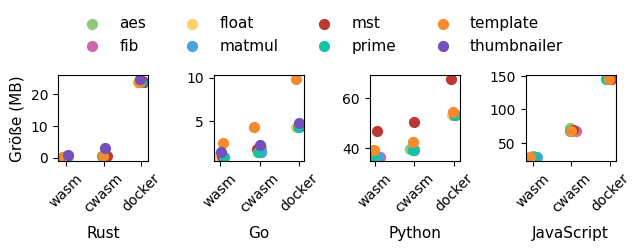

In [4]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(6.5, 2), width_ratios=[1, 1, 1, 1])

# plot scattered points for each function, mode and language
for lang, ax in zip(LANGUAGES, (ax1, ax2, ax3, ax4)):  # iterator over tuples(lang,ax)
    lang_data = size_data[size_data["language"] == lang]
    functions = lang_data["function"].unique()
    for i, mode in enumerate(MODES):
        scatter_data = []
        for fn in functions:
            size = lang_data.loc[lang_data["function"] == fn, mode].values
            scatter_data.append((fn, size))

        for fn, size in scatter_data:
            x_jitter = np.random.normal(loc=i, scale=0.05)
            ax.scatter(x_jitter, size, color=FN_COLORS[fn], label=fn, s=50)
    ax.set_xticks(range(len(MODES)))
    ax.set_xticklabels(MODES, fontsize=10)
    ax.tick_params(axis="x", labelrotation=45)
    ax.set_xlabel(lang, fontsize=11, labelpad=8)

# plot config
ax1.set_ylabel("Größe (MB)", fontsize=11)
handles, labels = ax1.get_legend_handles_labels()
unique_labels = dict(zip(labels, handles))
fig.legend(
    unique_labels,
    loc="upper center",
    bbox_to_anchor=(0.5, 1.27),
    ncol=4,
    frameon=False,
    fontsize=11
)

plt.tight_layout()
plt.savefig(f"{DIAGRAM_DIR}/artefakte.pdf", bbox_inches="tight")
plt.show()

##### 2 | Rust

In [5]:
def size_overview(lang):
    lang_sizes = size_data[size_data["language"] == lang]
    mean_row = lang_sizes.mean(numeric_only=True)
    mean_row["function"] = "MEAN"
    mean_row["language"] = lang
    std_row = lang_sizes.std(numeric_only=True)
    std_row["function"] = "STD"
    std_row["language"] = lang
    return pd.concat([lang_sizes, pd.DataFrame([mean_row]), pd.DataFrame([std_row])])


size_overview("Rust").round(2)

,function,language,wasm,cwasm,docker,cwasm/wasm,docker/wasm,docker/cwasm
3,aes,Rust,0.16,0.55,24.06,3.51,152.34,43.46
7,fib,Rust,0.12,0.43,24.00,3.53,196.03,55.56
11,float,Rust,0.16,0.55,24.02,3.42,150.30,43.91
15,matmul,Rust,0.16,0.54,24.03,3.48,154.58,44.45
19,mst,Rust,0.17,0.60,24.06,3.45,138.35,40.06
23,prime,Rust,0.13,0.44,24.00,3.51,191.20,54.42
27,template,Rust,0.14,0.50,24.03,3.53,169.25,47.89
29,thumbnailer,Rust,0.85,2.89,24.84,3.41,29.30,8.60
0,MEAN,Rust,0.24,0.81,24.13,3.48,147.67,42.29
0,STD,Rust,0.25,0.84,0.29,0.05,51.93,14.66


##### 3 | Go

In [6]:
size_overview("Go").round(2)

,function,language,wasm,cwasm,docker,cwasm/wasm,docker/wasm,docker/cwasm
0,aes,Go,1.06,1.83,4.60,1.73,4.34,2.51
4,fib,Go,0.77,1.39,4.23,1.81,5.52,3.05
8,float,Go,0.78,1.41,4.24,1.82,5.47,3.01
12,matmul,Go,0.77,1.40,4.24,1.82,5.50,3.03
16,mst,Go,0.93,1.70,4.41,1.82,4.73,2.59
20,prime,Go,0.77,1.39,4.23,1.81,5.52,3.04
24,template,Go,2.45,4.29,9.82,1.75,4.01,2.29
28,thumbnailer,Go,1.32,2.20,4.74,1.67,3.59,2.16
0,MEAN,Go,1.11,1.95,5.06,1.78,4.84,2.71
0,STD,Go,0.58,0.99,1.93,0.06,0.78,0.37


##### 4 | Python

In [7]:
size_overview("Python").round(2)

,function,language,wasm,cwasm,docker,cwasm/wasm,docker/wasm,docker/cwasm
2,aes,Python,36.43,39.33,53.08,1.08,1.46,1.35
6,fib,Python,36.18,39.07,52.95,1.08,1.46,1.36
10,float,Python,36.17,39.07,52.95,1.08,1.46,1.36
14,matmul,Python,36.18,39.07,52.95,1.08,1.46,1.36
18,mst,Python,46.78,50.35,67.53,1.08,1.44,1.34
22,prime,Python,36.17,39.07,52.95,1.08,1.46,1.36
26,template,Python,39.12,42.35,54.21,1.08,1.39,1.28
0,MEAN,Python,38.15,41.19,55.23,1.08,1.45,1.34
0,STD,Python,3.96,4.22,5.44,0.00,0.03,0.03


##### 5 | JavaScript

In [8]:
size_overview("JavaScript").round(2)

,function,language,wasm,cwasm,docker,cwasm/wasm,docker/wasm,docker/cwasm
1,aes,JavaScript,30.33,72.14,145.26,2.38,4.79,2.01
5,fib,JavaScript,28.71,67.51,145.19,2.35,5.06,2.15
9,float,JavaScript,28.72,67.52,145.19,2.35,5.06,2.15
13,matmul,JavaScript,28.75,67.63,145.19,2.35,5.05,2.15
17,mst,JavaScript,29.28,69.66,145.22,2.38,4.96,2.08
21,prime,JavaScript,28.72,67.54,145.19,2.35,5.06,2.15
25,template,JavaScript,28.94,68.33,145.22,2.36,5.02,2.13
0,MEAN,JavaScript,29.06,68.62,145.21,2.36,5.00,2.12
0,STD,JavaScript,0.60,1.74,0.03,0.01,0.10,0.05


##### 6 | Language Comparison

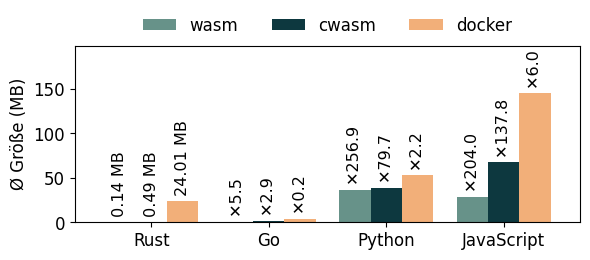

In [9]:
# prepare data
micros = size_data[size_data["function"].isin(MICRO_BENCHMARKS)]
mean = (micros
        .groupby("language")[["wasm", "cwasm", "docker"]]
        .mean()
        .reset_index().set_index("language")
        )
mean.index = pd.Categorical(mean.index, categories=LANGUAGES, ordered=True)
mean = mean.sort_index()

factors = mean.div(mean.loc["Rust"], axis=1)

# plot config
ax = mean.plot(
    kind="bar",
    rot=0,
    figsize=(6, 2.8),
    color=COLOR_ORDER,
    width=0.8
)
ax_max = mean.max().max() * 1.37
plt.ylim(0, ax_max)
ax.tick_params(axis="x", labelsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_xlabel("", fontsize=12)
ax.set_ylabel("Ø Größe (MB)", fontsize=12)
ax.legend(fontsize=12, loc="upper center", frameon=False, bbox_to_anchor=(0.5, 1.25), ncol=3)

# add factors
for bar_group, mode in zip(ax.containers, mean.columns):
    for bar, lang in zip(bar_group, LANGUAGES):
        height = bar.get_height()
        factor = factors.loc[lang, mode]

        if lang != "Rust":
            text = f" ✕{factor:.1f}"
        else:
            value = mean.loc[lang, mode]
            text = f" {value:.2f} MB"

        ax.text(
            bar.get_x() + bar.get_width() / 2,  # x center of bar
            height,  # y for above bar
            text,
            ha="center",
            va="bottom",
            fontsize=11.5,
            rotation=90,
        )

plt.tight_layout()
plt.savefig(f"{DIAGRAM_DIR}/artefakte_vergleich.pdf", bbox_inches="tight")
plt.show()

### III. Performance
Performance is evaluated by analyzing the coldstart, computation and response time in ms across runtimes.

**Coldstart time** describes the time between starting the runtime and function and the first code execution (timestamp2 - timestamp1). \
**Computation time** describes the time the function is actually running (timestamp3 - timestamp2).\
**Response time** describes the time the function needs from start to output of the result (timestamp3 - timestamp1).

##### Helper functions

In [10]:
def coldstart(lang):
    """
    Calculate mean coldstart per mode and function as well as mean and std per mode for the given language.
    """
    lang_data = performance_data[performance_data["language"] == lang]
    mean_row = lang_data.groupby("mode", as_index=False).mean(numeric_only=True)[["mode", "coldstart_ms"]]
    mean_row["function"] = "MEAN"
    std_row = lang_data.groupby("mode", as_index=False).std(numeric_only=True)[["mode", "coldstart_ms"]]
    std_row["function"] = "STD"
    lang_data = (lang_data[["function", "mode", "coldstart_ms"]]
                 .groupby(["function", "mode"])
                 .agg(coldstart_ms=("coldstart_ms", "mean"))
                 ).reset_index()
    return pd.concat([lang_data, mean_row, std_row], axis=0, ignore_index=True).pivot(index="function", columns="mode", values="coldstart_ms")

def response_time_factors(lang):
    """
    Calculates the performance factors between modes per function and input size for the given language.
    """
    lang_data = performance_data[performance_data["language"] == lang]
    # unstack -> create column (response_ms, mode) for each mode for calculating factors
    lang_data = lang_data[["mode", "function", "input", "response_ms"]].groupby(
        ["mode", "function", "input"]).mean().unstack(level="mode")
    lang_data = lang_data.drop([("response_ms", "local")], axis=1)  # not needed for this

    lang_data["wasm/cwasm"] = lang_data[("response_ms", "wasm")] / lang_data[("response_ms", "cwasm")]
    lang_data["docker/wasm"] = lang_data[("response_ms", "docker")] / lang_data[("response_ms", "wasm")]
    lang_data["docker/cwasm"] = lang_data[("response_ms", "docker")] / lang_data[("response_ms", "cwasm")]
    lang_data["cwasm/docker"] = lang_data[("response_ms", "cwasm")] / lang_data[("response_ms", "docker")]
    lang_data["wasm/docker"] = lang_data[("response_ms", "wasm")] / lang_data[("response_ms", "docker")]

    return lang_data


def computation_slowdown_vs_local(lang):
    """
    Calculates the computation slowdown caused by the execution mode per function and input size for the given language.
    """
    lang_data = performance_data[performance_data["language"] == lang]
    lang_data = lang_data[["mode", "function", "input", "computation_ms"]].groupby(["mode", "function", "input"]).mean()
    lang_data = lang_data.div(lang_data.loc["local"], axis=0).sort_values(by=["mode", "function"]).rename(
        columns={"computation_ms": "factor vs local"}).reset_index()

    return lang_data[lang_data["mode"].isin(["wasm", "cwasm"])].pivot(index="function", columns=["mode", "input"],
                                                                      values="factor vs local")

def create_broken_axis_plot(df, ax_left, ax_right, all_fns, outlier_threshold):
    # calculate min and max x for both subplots to show relevant data
    left_max = df[df < outlier_threshold].max().max() / TO_MS * 1.05
    right_min = max(left_max, df[df >= outlier_threshold].min().min() / TO_MS * 0.9)
    right_max = df.max().max() / TO_MS * 1.1
    ax_left.set_xlim(0, left_max)
    ax_right.set_xlim(right_min, right_max)

    # plot config
    bar_width = 0.2
    ax_right.spines["left"].set_visible(False)
    ax_right.get_yaxis().set_visible(False)  # hide y-ticks
    ax_left.spines["right"].set_visible(False)
    y_ticks = np.arange(len(all_fns))
    ax_left.set_yticks(y_ticks)
    ax_left.set_yticklabels(all_fns, fontsize=13)
    for ax in (ax_left, ax_right):
        ax.tick_params(axis="x", labelsize=13, pad=3)

    # mark broken axis / /
    kwargs = dict(marker=[(-1, -90), (1, 90)],
                  markersize=8, linestyle="none", color="k", clip_on=False)
    ax_left.plot([1, 1], [1, 0], transform=ax_left.transAxes, **kwargs)
    ax_right.plot([0, 0], [0, 1], transform=ax_right.transAxes, **kwargs)

    # plot stacking bars for each mode per fn
    offset = [-0.2, +0.0, +0.2]
    for i, mode in enumerate(MODES):
        coldstart = df[("coldstart_ms", "mean"), mode] / TO_MS
        computation = df[("computation_ms", "mean"), mode] / TO_MS
        y_pos = y_ticks + offset[i]
        for ax in (ax_left, ax_right):
            ax.barh(
                y=y_pos,
                width=computation,
                height=bar_width,
                left=coldstart,  # stack it right of coldstart bar
                label=f"{mode}",
                color=COLOR_MAP[mode],
            )
            ax.barh(
                y=y_pos,
                width=coldstart,
                height=bar_width,
                label="coldstart",
                color=COLDSTART,
            )

def get_data_for_input(data, input_name, all_fns):
    input_data = data[data["input"] == input_name]

    # pivot table for easier plotting -> long to wide dataframe
    pivot = input_data.pivot(
        index="function",
        columns="mode",  # modes become columns
        values=[("coldstart_ms", "mean"), ("computation_ms", "mean"), ("response_ms", "mean")]
    )
    return pivot.reindex(all_fns)


def create_plot(df, ax, all_fns):
    # plot config
    bar_width = 0.2
    y_ticks = np.arange(len(all_fns))
    ax.set_yticks(y_ticks)
    ax.set_yticklabels(all_fns, fontsize=13)
    ax.tick_params(axis="x", labelsize=13, pad=3)

    # plot stacking bars for each mode per fn
    offset = [-0.2, +0.0, +0.2]
    for i, mode in enumerate(MODES):
        coldstart = df[("coldstart_ms", "mean"), mode] / TO_MS
        computation = df[("computation_ms", "mean"), mode] / TO_MS
        y_pos = y_ticks + offset[i]
        ax.barh(
            y=y_pos,
            width=computation,
            height=bar_width,
            left=coldstart,  # stack it right of coldstart bar
            label=f"{mode}",
            color=COLOR_MAP[mode],
        )
        ax.barh(
            y=y_pos,
            width=coldstart,
            height=bar_width,
            label="coldstart",
            color=COLDSTART,
        )


def performance_plot(lang, small_threshold=0, large_threshold=0):
    """
    Plots the performance stacking plot (coldstart + computation time = response time)
    for small and large input into one figure.
    If a threshold is specified for either input size, a broken axis is used.
    The break is indicated by the thresholds.
    https://matplotlib.org/stable/gallery/subplots_axes_and_figures/broken_axis.html
    """
    lang_data = (performance_data[performance_data["language"] == lang]
                 .groupby(["language", "mode", "function", "input"])
                 .agg(["mean"])
                 .reset_index()
                 )
    functions = lang_data["function"].unique()

    small = get_data_for_input(lang_data, "small", functions)
    large = get_data_for_input(lang_data, "large", functions)

    if small_threshold == 0:
        s_split = False
        s_col = 1
        s_ratio = [4.5]
    else:
        s_split = True
        s_col = 2
        s_ratio = [3,1]

    if large_threshold == 0:
        l_split = False
        l_col = 1
        l_ratio = [4.5]
    else:
        l_split = True
        l_col = 2
        l_ratio = [3,1]

    fig, axes = plt.subplots(
        nrows=1,
        ncols=s_col+l_col,
        figsize=(8, 4),
        gridspec_kw={"width_ratios": s_ratio+l_ratio, "wspace": 0.15},
        sharey=False,
    )
    i=0
    print(s_ratio+l_ratio)
    if s_split:
        ax1 = i
        i = i+1
        create_broken_axis_plot(small, axes[ax1], axes[i], functions, outlier_threshold=small_threshold)
    else:
        create_plot(small, axes[i], functions)

    if l_split:
        ax1 = i = i+1
        i = i+1
        create_broken_axis_plot(large, axes[ax1], axes[i], functions, outlier_threshold=large_threshold)
        axes[ax1].get_yaxis().set_visible(False)
    else:
        ax1 = i+1
        create_plot(large, axes[ax1], functions)
        axes[ax1].get_yaxis().set_visible(False)

    # plot config
    handles, labels = axes[0].get_legend_handles_labels()
    label2handle = dict(zip(labels, handles))  # unique labels legend
    label_order = ["coldstart", "wasm", "cwasm", "docker"]
    ordered = [label2handle[lbl] for lbl in label_order if lbl in label2handle]
    plt.subplots_adjust(bottom=0.20, top=0.85, wspace=0.05)
    fig.text(
        0.5,
        0.05,
        "Ø Zeit (s)",
        ha="center",
        va="bottom",
        fontsize=13
    )

    fig.legend(
        ordered,
        label_order,
        loc="upper center",
        bbox_to_anchor=(0.5, 0.98),
        ncol=4,
        frameon=False,
        fontsize=13
    )
    plt.savefig(f"{DIAGRAM_DIR}/performance_{lang}.pdf", bbox_inches="tight")
    plt.show()

#### 1 | Rust

##### Performance Plot for small and large input

[3, 1, 3, 1]


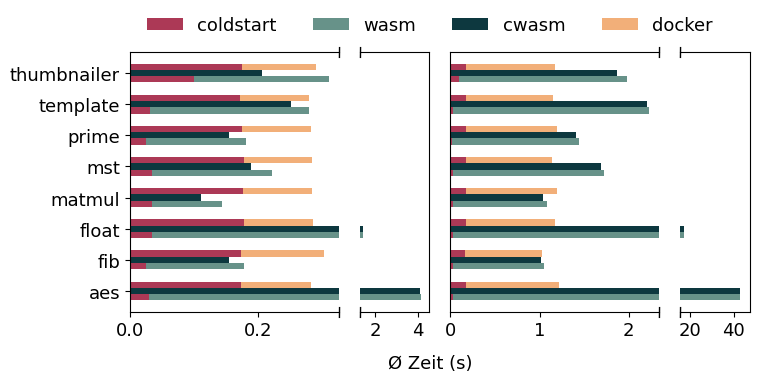

In [11]:
performance_plot("Rust", small_threshold=600, large_threshold=2500)

##### Coldstart times per function and mode

In [12]:
coldstart("Rust").round(1)

mode,cwasm,docker,local,wasm
function,,,,
MEAN,0.8,174.1,1.7,37.8
STD,0.1,10.0,0.4,21.5
aes,0.8,174.3,1.7,30.0
fib,0.8,171.5,1.7,25.1
float,0.8,175.9,1.8,35.7
matmul,0.8,174.8,1.8,35.4
mst,0.8,175.9,1.8,34.9
prime,0.7,174.0,1.6,24.8
template,0.8,172.0,1.7,31.2


##### Response Time factors wasm/cwasm vs. docker

In [13]:
response_time_factors("Rust").round(2)

response_ms                    wasm/cwasm docker/wasm  \
mode                     cwasm   docker      wasm                          
function    input                                                          
aes         large     43082.80  1218.90  43044.44       1.00        0.03   
            small      4119.66   282.27   4150.53       1.01        0.07   
fib         common       98.54   254.93    119.78       1.22        2.13   
            large      1021.05  1031.36   1047.75       1.03        0.98   
            small       153.89   301.78    177.30       1.15        1.70   
float       common      496.81   232.90    525.15       1.06        0.44   
            large     17049.14  1172.00  17192.21       1.01        0.07   
            small      1393.23   285.19   1426.46       1.02        0.20   
matmul      common       60.77   229.60     91.81       1.51        2.50   
            large      1035.41  1190.41   1079.68       1.04        1.10   
            small       111.19   283.79    142.85       1.28        1.99   
mst         large      1684.74  1141.67   1716.52       1.02        0.67   
            small       188.52   283.71    221.05       1.17        1.28   
prime       common      124.71   256.72    146.70       1.18        1.75   
            large      1410.13  1192.67   1440.69       1.02        0.83   
            small       154.63   282.03    180.54       1.17        1.56   
template    large      2204.82  1152.77   2229.73       1.01        0.52   
            small       250.89   278.37    279.41       1.11        1.00   
thumbnailer large      1866.38  1172.65   1978.90       1.06        0.59   
            small       206.38   289.29    310.01       1.50        0.93   

                   docker/cwasm cwasm/docker wasm/docker  
mode                                                      
function    input                                         
aes         large          0.03        35.35       35.31  
            small          0.07        14.59       14.70  
fib         common         2.59         0.39        0.47  
            large          1.01         0.99        1.02  
            small          1.96         0.51        0.59  
float       common         0.47         2.13        2.25  
            large          0.07        14.55       14.67  
            small          0.20         4.89        5.00  
matmul      common         3.78         0.26        0.40  
            large          1.15         0.87        0.91  
            small          2.55         0.39        0.50  
mst         large          0.68         1.48        1.50  
            small          1.50         0.66        0.78  
prime       common         2.06         0.49        0.57  
            large          0.85         1.18        1.21  
            small          1.82         0.55        0.64  
template    large          0.52         1.91        1.93  
            small          1.11         0.90        1.00  
thumbnailer large          0.63         1.59        1.69  
            small          1.40         0.71        1.07

##### Computation time slow down with WebAssembly (wasm and cwasm)

In [14]:
computation_slowdown_vs_local("Rust").round(1)

mode        cwasm               wasm             
input       large small common large small common
function                                         
aes          41.6  38.7    NaN  41.5  38.8    NaN
fib           1.2   1.2    1.2   1.2   1.2    1.1
float        16.9  12.7    8.7  17.0  12.7    8.5
matmul        1.0   1.0    1.0   1.0   1.0    1.0
mst           1.7   1.8    NaN   1.7   1.8    NaN
prime         1.4   1.4    1.5   1.4   1.4    1.5
template      2.2   2.3    NaN   2.2   2.3    NaN
thumbnailer   1.9   1.8    NaN   1.9   1.9    NaN

#### 2 | Go

##### Performance Plot for small and large input

[3, 1, 3, 1]


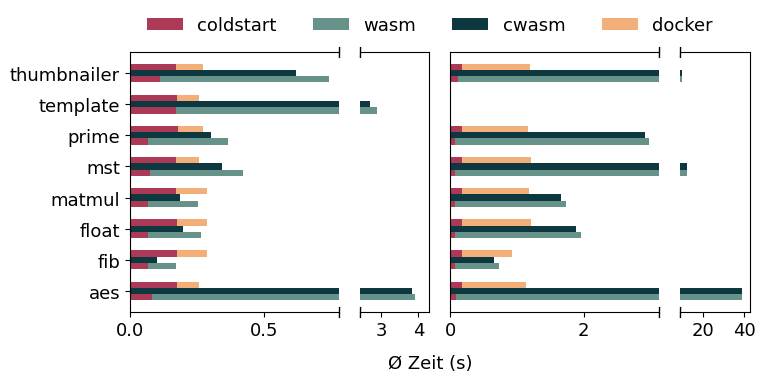

In [15]:
performance_plot("Go", small_threshold=800, large_threshold=3000)

##### Coldstart times per function and mode

In [16]:
coldstart("Go").round(1)

mode,cwasm,docker,local,wasm
function,,,,
MEAN,1.4,174.7,2.3,80.7
STD,0.4,10.3,0.5,26.0
aes,1.5,172.9,2.2,83.1
fib,1.5,174.4,2.2,69.1
float,1.4,174.7,2.2,68.0
matmul,1.4,174.8,2.2,68.0
mst,1.3,174.8,2.3,74.6
prime,1.4,177.5,2.3,67.3
template,2.1,176.3,3.9,171.1


##### Response Time factors wasm/cwasm vs. docker

In [17]:
response_time_factors("Go").round(2)

response_ms                    wasm/cwasm docker/wasm  \
mode                     cwasm   docker      wasm                          
function    input                                                          
aes         large     38610.98  1141.72  38767.41       1.00        0.03   
            small      3815.95   259.60   3903.58       1.02        0.07   
fib         common      102.06   287.28    170.07       1.67        1.69   
            large       648.34   932.15    724.83       1.12        1.29   
            small       102.65   287.68    170.37       1.66        1.69   
float       common      121.69   245.63    188.58       1.55        1.30   
            large      1889.25  1217.42   1956.91       1.04        0.62   
            small       199.42   288.11    267.30       1.34        1.08   
matmul      common       99.19   230.57    171.22       1.73        1.35   
            large      1665.97  1182.25   1733.45       1.04        0.68   
            small       187.10   286.03    256.01       1.37        1.12   
mst         large     12068.01  1205.20  12017.37       1.00        0.10   
            small       344.33   257.17    423.27       1.23        0.61   
prime       common      298.78   265.37    375.96       1.26        0.71   
            large      2914.03  1160.75   2984.76       1.02        0.39   
            small       303.82   274.22    367.01       1.21        0.75   
template    small      2699.93   259.19   2887.66       1.07        0.09   
thumbnailer large      9622.80  1191.94   9785.56       1.02        0.12   
            small       620.55   271.80    742.67       1.20        0.37   

                   docker/cwasm cwasm/docker wasm/docker  
mode                                                      
function    input                                         
aes         large          0.03        33.82       33.96  
            small          0.07        14.70       15.04  
fib         common         2.81         0.36        0.59  
            large          1.44         0.70        0.78  
            small          2.80         0.36        0.59  
float       common         2.02         0.50        0.77  
            large          0.64         1.55        1.61  
            small          1.44         0.69        0.93  
matmul      common         2.32         0.43        0.74  
            large          0.71         1.41        1.47  
            small          1.53         0.65        0.90  
mst         large          0.10        10.01        9.97  
            small          0.75         1.34        1.65  
prime       common         0.89         1.13        1.42  
            large          0.40         2.51        2.57  
            small          0.90         1.11        1.34  
template    small          0.10        10.42       11.14  
thumbnailer large          0.12         8.07        8.21  
            small          0.44         2.28        2.73

##### Computation time slow down with WebAssembly (wasm and cwasm)

In [18]:
computation_slowdown_vs_local("Go").round(1)

mode        cwasm               wasm             
input       large small common large small common
function                                         
aes          38.9  37.7    NaN  39.0  37.7    NaN
fib           0.8   0.9    0.9   0.9   0.9    0.9
float         1.8   1.8    1.7   1.8   1.8    1.7
matmul        1.7   1.7    1.7   1.7   1.7    1.8
mst          12.1   3.4    NaN  12.0   3.5    NaN
prime         2.9   2.9    3.3   2.9   2.9    3.4
template      NaN  26.7    NaN   NaN  26.9    NaN
thumbnailer   9.6   5.4    NaN   9.6   5.5    NaN

#### 3 | Python

##### Performance Plot for small and large input

[4.5, 4.5]


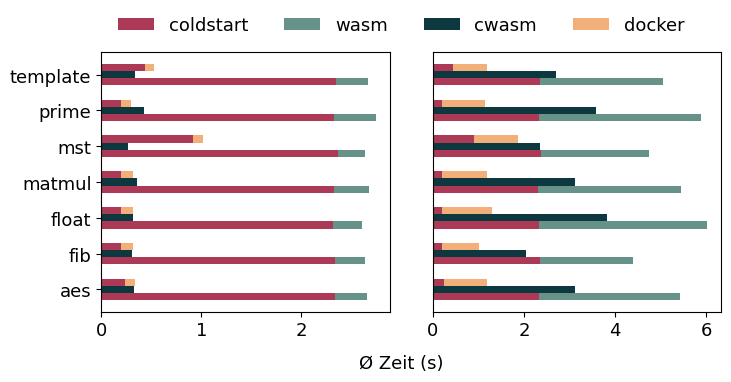

In [19]:
performance_plot("Python")

##### Coldstart times per function and mode

In [20]:
coldstart("Python").round(1)

mode,cwasm,docker,local,wasm
function,,,,
MEAN,10.4,308.3,34.3,2333.4
STD,1.8,226.1,38.4,64.2
aes,10.5,237.1,17.7,2326.5
fib,10.2,195.7,16.5,2329.9
float,10.0,197.6,15.6,2326.2
matmul,10.9,201.1,16.5,2315.9
mst,9.3,911.7,136.3,2374.9
prime,11.0,199.0,16.4,2327.1
template,10.8,435.8,57.0,2350.5


##### Response Time factors wasm/cwasm vs. docker

In [21]:
response_time_factors("Python").round(2)

response_ms                    wasm/cwasm docker/wasm  \
mode                  cwasm   docker      wasm                          
function input                                                          
aes      large      3118.37  1185.76   5415.58       1.74        0.22   
         small       329.11   336.42   2657.96       8.08        0.13   
fib      common     8661.45  3579.65  11024.65       1.27        0.32   
         large      2052.03  1003.53   4397.68       2.14        0.23   
         small       309.63   318.00   2635.58       8.51        0.12   
float    common     1963.73   812.57   4264.97       2.17        0.19   
         large      3811.39  1291.48   6023.59       1.58        0.21   
         small       313.54   319.47   2608.74       8.32        0.12   
matmul   common     3754.50  1392.85   6090.33       1.62        0.23   
         large      3125.65  1189.58   5445.99       1.74        0.22   
         small       353.44   312.71   2678.61       7.58        0.12   
mst      large      2355.56  1857.32   4744.37       2.01        0.39   
         small       271.21  1015.83   2632.00       9.70        0.39   
prime    common     3801.53  1224.14   6149.72       1.62        0.20   
         large      3572.58  1149.22   5887.53       1.65        0.20   
         small       429.58   302.52   2745.03       6.39        0.11   
template large      2703.83  1191.56   5045.24       1.87        0.24   
         small       336.68   526.64   2670.21       7.93        0.20   

                docker/cwasm cwasm/docker wasm/docker  
mode                                                   
function input                                         
aes      large          0.38         2.63        4.57  
         small          1.02         0.98        7.90  
fib      common         0.41         2.42        3.08  
         large          0.49         2.04        4.38  
         small          1.03         0.97        8.29  
float    common         0.41         2.42        5.25  
         large          0.34         2.95        4.66  
         small          1.02         0.98        8.17  
matmul   common         0.37         2.70        4.37  
         large          0.38         2.63        4.58  
         small          0.88         1.13        8.57  
mst      large          0.79         1.27        2.55  
         small          3.75         0.27        2.59  
prime    common         0.32         3.11        5.02  
         large          0.32         3.11        5.12  
         small          0.70         1.42        9.07  
template large          0.44         2.27        4.23  
         small          1.56         0.64        5.07

##### Computation time slow down with WebAssembly (wasm and cwasm)

In [22]:
computation_slowdown_vs_local("Python").round(1)

mode     cwasm               wasm             
input    large small common large small common
function                                      
aes        3.1   3.1    NaN   3.1   3.1    NaN
fib        2.4   2.4    2.4   2.4   2.4    2.4
float      3.7   2.8    3.4   3.6   2.7    3.3
matmul     3.2   3.3    3.0   3.2   3.4    3.0
mst        2.3   2.4    NaN   2.3   2.4    NaN
prime      3.6   4.0    3.6   3.6   4.0    3.6
template   2.9   2.9    NaN   2.9   2.9    NaN

#### 4 | JavaScript

##### Performance Plot for small and large input

[4.5, 3, 1]


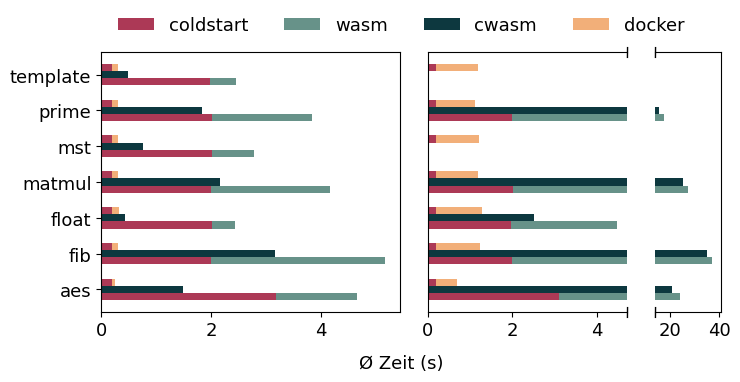

In [23]:
performance_plot("JavaScript", large_threshold=4500)

##### Coldstart times per function and mode

In [24]:
coldstart("JavaScript").round(1)

mode,cwasm,docker,local,wasm
function,,,,
MEAN,7.0,200.1,29.6,2141.6
STD,1.4,11.5,2.6,388.8
aes,6.7,202.6,31.1,3141.8
fib,7.6,199.6,29.3,1986.8
float,6.8,198.5,29.1,1995.1
matmul,7.0,201.4,29.3,2005.0
mst,7.1,199.2,30.1,2018.1
prime,7.0,201.3,29.2,2006.7
template,6.4,198.4,29.8,1983.9


##### Response Time factors wasm/cwasm vs. docker

In [25]:
response_time_factors("JavaScript").round(2)

response_ms                    wasm/cwasm docker/wasm  \
mode                  cwasm   docker      wasm                          
function input                                                          
aes      large     21076.36   682.29  24156.25       1.15        0.03   
         small      1491.26   259.38   4652.38       3.12        0.06   
fib      common     8259.96   451.98  10393.64       1.26        0.04   
         large     35023.53  1238.31  37023.38       1.06        0.03   
         small      3161.22   298.27   5166.31       1.63        0.06   
float    common      935.45   553.13   2944.40       3.15        0.19   
         large      2498.43  1281.89   4478.16       1.79        0.29   
         small       426.43   315.77   2428.50       5.69        0.13   
matmul   common     2400.95   316.42   4429.20       1.84        0.07   
         large     25225.08  1190.88  27397.37       1.09        0.04   
         small      2160.84   310.95   4157.82       1.92        0.07   
mst      large          NaN  1218.27       NaN        NaN         NaN   
         small       766.51   302.74   2776.32       3.62        0.11   
prime    common     5598.90   525.14   7589.05       1.36        0.07   
         large     15646.44  1117.15  17589.86       1.12        0.06   
         small      1831.38   313.32   3823.70       2.09        0.08   
template large          NaN  1188.82       NaN        NaN         NaN   
         small       481.49   307.70   2457.17       5.10        0.13   

                docker/cwasm cwasm/docker wasm/docker  
mode                                                   
function input                                         
aes      large          0.03        30.89       35.40  
         small          0.17         5.75       17.94  
fib      common         0.05        18.27       23.00  
         large          0.04        28.28       29.90  
         small          0.09        10.60       17.32  
float    common         0.59         1.69        5.32  
         large          0.51         1.95        3.49  
         small          0.74         1.35        7.69  
matmul   common         0.13         7.59       14.00  
         large          0.05        21.18       23.01  
         small          0.14         6.95       13.37  
mst      large           NaN          NaN         NaN  
         small          0.39         2.53        9.17  
prime    common         0.09        10.66       14.45  
         large          0.07        14.01       15.75  
         small          0.17         5.85       12.20  
template large           NaN          NaN         NaN  
         small          0.64         1.56        7.99

##### Computation time slow down with WebAssembly (wasm and cwasm)

In [26]:
computation_slowdown_vs_local("JavaScript").round(1)

mode     cwasm               wasm             
input    large small common large small common
function                                      
aes       40.4  27.5    NaN  40.4  27.3    NaN
fib       34.1  33.3   33.7  34.2  33.4   34.3
float      2.4   3.8    2.8   2.5   3.8    2.8
matmul    25.1  21.3   20.9  25.3  21.4   21.1
mst        NaN   7.2    NaN   NaN   7.2    NaN
prime     17.3  16.7   17.6  17.3  16.6   17.5
template   NaN   4.2    NaN   NaN   4.2    NaN

#### 5 | Comparison

##### Comparison Plot

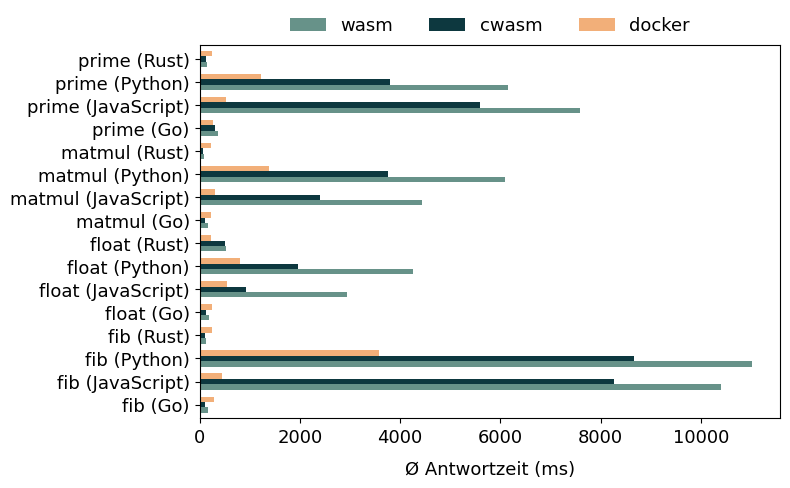

In [27]:
# prepare data -> microbenchmarks with common input
micros = performance_data[performance_data["function"].isin(MICRO_BENCHMARKS)]
common_input = micros[micros["input"] == "common"]

mean_responses = (common_input
                  .groupby(["function", "mode", "language"])["response_ms"]
                  .agg(["mean"])
                  .reset_index()
                  )
mean_responses["label"] = mean_responses["function"] + " (" + mean_responses["language"] + ")"
mean_responses = mean_responses.sort_values(by="label")

pivot = mean_responses.pivot(index="label", columns="mode", values="mean")
pivot = pivot[["wasm", "cwasm", "docker"]]

# plot
ax = pivot.plot(
    kind="barh",
    figsize=(8, 5),
    color=COLOR_ORDER,
    width=0.7
)

# plot config
ax.set_xlabel("Ø Antwortzeit (ms)", fontsize=13, labelpad=10)
ax.set_ylabel("")
ax.tick_params(labelsize=13)
ax.legend(fontsize=13, loc="upper center", frameon=False, bbox_to_anchor=(0.5, 1.12), ncol=3)

plt.tight_layout()
plt.savefig(f"{DIAGRAM_DIR}/performance_Vergleich.pdf", bbox_inches="tight")
plt.show()

##### Factors with Rust as baseline

In [28]:
rust_base = mean_responses[mean_responses["language"] == "Rust"]

pivot = (mean_responses
         .pivot(index=["function", "mode"], columns="language", values="mean")
         )
pivot.div(pivot["Rust"], axis=0).round(1)

language          Go  JavaScript  Python  Rust
function mode                                 
fib      cwasm   1.0        83.8    87.9   1.0
         docker  1.1         1.8    14.0   1.0
         local   1.4         3.2    43.2   1.0
         wasm    1.4        86.8    92.0   1.0
float    cwasm   0.2         1.9     4.0   1.0
         docker  1.1         2.4     3.5   1.0
         local   1.2         6.2    10.0   1.0
         wasm    0.4         5.6     8.1   1.0
matmul   cwasm   1.6        39.5    61.8   1.0
         docker  1.0         1.4     6.1   1.0
         local   1.0         2.4    21.5   1.0
         wasm    1.9        48.2    66.3   1.0
prime    cwasm   2.4        44.9    30.5   1.0
         docker  1.0         2.0     4.8   1.0
         local   1.1         4.2    13.0   1.0
         wasm    2.6        51.7    41.9   1.0

##### Coldstarts

In [29]:
mean_coldstart = (micros
                   .groupby(["language", "mode"])["coldstart_ms"]
                   .agg(["mean", "std"])
                   .reset_index()
                   )

pivot = mean_coldstart.pivot(index="language", columns="mode", values=["mean", "std"])
pivot.round(1)

mean                        std                   
mode       cwasm docker local    wasm cwasm docker local  wasm
language                                                      
Go           1.4  175.3   2.2    68.1   0.5   10.8   0.3   3.8
JavaScript   7.1  200.2  29.2  1998.4   1.4   12.1   2.5  84.8
Python      10.5  198.3  16.2  2324.8   1.7   10.3   2.5  62.6
Rust         0.7  174.0   1.7    30.2   0.1   10.1   0.4   6.5